In [16]:
# EXTERNAL DEPENDENCIES

import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.linalg import solve
from pylops.utils import wavelets

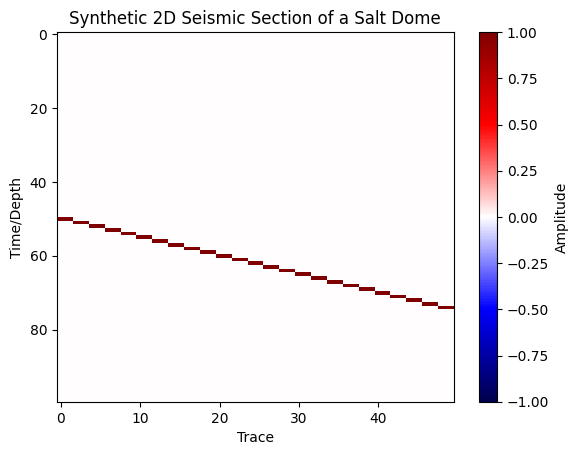

In [17]:
# Synthetic seismic data, activate salt dome or dipping event, or other, as needed

n_rows, n_cols = 100, 50  # Number of rows (time/depth) and columns (trace locations)
salt_dome_radius = 5  # Approximate radius of the salt dome
salt_dome_depth = 50  # Starting depth of the dome
amplitude = 1  # Seismic amplitude for reflection
wavelet, wavt, wavc = wavelets.ricker(np.linspace(0, 50, 50), f0=20)  # Ricker wavelet to simulate seismic wavelet

# Initialize array
seismic_data = np.zeros((n_rows, n_cols))


# Activate/Deactivate salt dome
## Salt dome shape using a parabolic profile
#for i in range(n_rows):
#    for j in range(n_cols):
#        depth = salt_dome_depth + (j - n_cols // 2)**2 / (2 * salt_dome_radius)
#        if i < depth:
#            seismic_data[i, j] = amplitude  # Set amplitude for salt dome area
#
## Shift and substract to simulate a horizon
#seismic_data_temp = np.zeros((n_rows, n_cols))
#seismic_data_temp[0:n_rows-1, :] = seismic_data[1:, :]
#seismic_data = seismic_data - seismic_data_temp

# Activate/Deactivate dipping event
# Dipping event
dip = 0.5
event_center = 50
for col in range(n_cols):
    shift = int(dip * col)  # Linear shift due to dipping
    seismic_data[event_center + shift, col] = amplitude


# Convolution with the Ricker wavelet
for col in range(n_cols):
    seismic_data[:, col] = np.convolve(seismic_data[:, col], wavelet, mode='same')


# Plot input data

plt.imshow(seismic_data, cmap='seismic', aspect='auto', origin='upper', vmin=-1, vmax=1)
plt.colorbar(label='Amplitude')
plt.title('Synthetic 2D Seismic Section of a Salt Dome')
plt.xlabel('Trace')
plt.ylabel('Time/Depth')
plt.show()

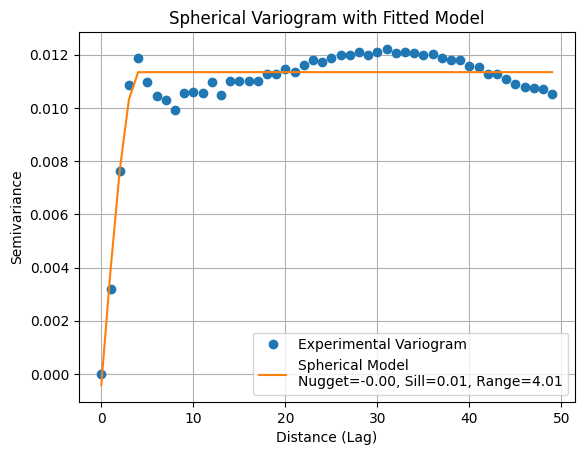

In [7]:
# Variogram computation

# Grid for seismic section
grid_points = []
for i in range(n_rows):
    for j in range(n_cols):
        grid_points.append((i, j))
grid_points = np.array(grid_points)

# Geodesic distance computation
def geodesic_distance(p1, p2, dome_radius=salt_dome_radius, dome_depth=salt_dome_depth):
    # TO DO: develop geodesic dstance computation
    # Geodesic distance includes both Euclidean distance and depth variation
    dist_euclidean = np.linalg.norm(np.array(p1) - np.array(p2))
    #print(f"dist_euclidean = {dist_euclidean}")
    depth_diff = abs(seismic_data[p1[0], p1[1]] - seismic_data[p2[0], p2[1]])
    #print(f"depth_diff = {depth_diff}")
    return dist_euclidean #+ depth_diff

# Geodesic distances between points
geodesic_distances = np.zeros((len(grid_points), len(grid_points)))
for i in range(len(grid_points)):
    for j in range(len(grid_points)):
        geodesic_distances[i, j] = geodesic_distance(grid_points[i], grid_points[j])

# Variogram computation
def compute_variogram(data, distances, lag_step=1, max_lag=50):
    lags = np.arange(0, max_lag, lag_step)
    variogram = np.zeros_like(lags, dtype=float)

    for i, lag in enumerate(lags):
        # Find all point pairs within a certain lag range
        mask = (distances >= lag) & (distances < lag + lag_step)
        point_pairs = np.argwhere(mask)
        
        if point_pairs.size > 0:
            differences = data[point_pairs[:, 0]] - data[point_pairs[:, 1]]
            variogram[i] = np.mean(differences**2) / 2
        else:
            variogram[i] = np.nan

    return lags, variogram

flattened_data = seismic_data.ravel()

# Experimental variogram with geodesic distances
lags, experimental_variogram = compute_variogram(flattened_data, geodesic_distances)

# Variogram model fit

# Spherical variogram model
def spherical_model(h, nugget, sill, range_):
    return np.where(h <= range_,
                    nugget + (sill - nugget) * (1.5 * (h / range_) - 0.5 * (h / range_)**3),
                    sill)

# Model fit to experimental variogram
initial_params = [0.1, 1, 10]  # Initial guess for nugget, sill, range
valid = ~np.isnan(experimental_variogram)  # Remove NaN values for fitting
var_parameters, _ = curve_fit(spherical_model, lags[valid], experimental_variogram[valid], p0=initial_params)

# Fitted variogram curve
fitted_variogram = spherical_model(lags, *var_parameters)


# Plots
plt.plot(lags, experimental_variogram, 'o', label='Experimental Variogram')
plt.plot(lags, fitted_variogram, '-', label=f'Spherical Model\nNugget={var_parameters[0]:.2f}, Sill={var_parameters[1]:.2f}, Range={var_parameters[2]:.2f}')
plt.title('Spherical Variogram with Fitted Model')
plt.xlabel('Distance (Lag)')
plt.ylabel('Semivariance')
plt.legend()
plt.grid()
plt.show()

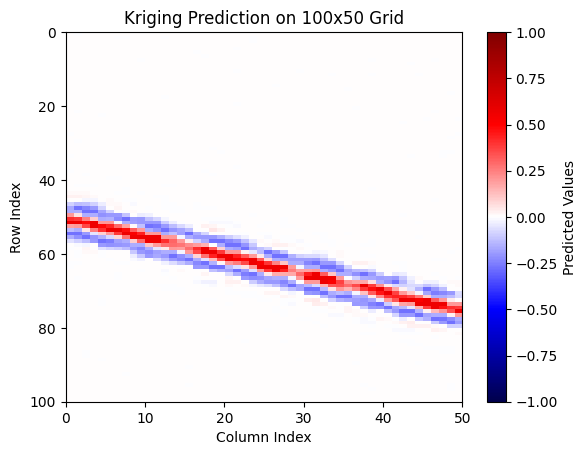

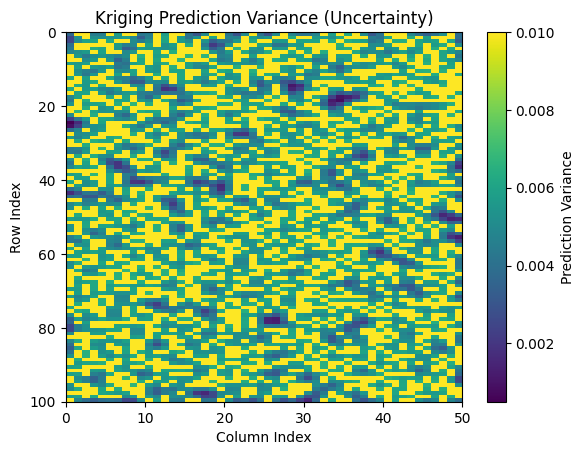

In [9]:
# Kriging prediction using previous variogram

# Parameters from previous fitted variogram
#nugget, sill, range_ = var_parameters
nugget, sill, range_ = 0.0, 0.01, 3.57

# Create different grid if needed
#n_rows, n_cols =
#grid_points = 

# Ordinary kriging prediction
def kriging_prediction(grid_points, known_points, known_values, spherical_model, nugget, sill, range_):
    # Distance between all grid points and known points
    dist_matrix = distance_matrix(grid_points, known_points)
    
    # Covariance matrix between known points
    known_dist_matrix = distance_matrix(known_points, known_points)
    cov_known = spherical_model(known_dist_matrix, nugget, sill, range_)

    # Covariance between grid points and known points
    cov_grid_known = spherical_model(dist_matrix, nugget, sill, range_)
    
    # Kriging system solution: λ * cov_known = cov_grid_known
    weights = solve(cov_known, cov_grid_known.T)

    # Prediction as weighted sum of known values
    predictions = weights.T @ known_values
    
    # Variance estimation: σ² = sill - (cov_grid_known.T * λ)
    prediction_variances = sill - np.einsum('ij,ij->i', weights.T, cov_grid_known)
    
    return predictions, prediction_variances

# Known points and corresponding values (in this case from input seismic grid)
known_indices = np.random.choice(range(n_rows * n_cols), size=2000, replace=False)
known_points = grid_points[known_indices]
known_values = seismic_data.ravel()[known_indices]

# Kriging Prediction of all points in the grid
predicted_values, predicted_variances = kriging_prediction(grid_points, known_points, known_values, spherical_model, nugget, sill, range_)

# Reshape
predicted_values_2d = predicted_values.reshape(n_rows, n_cols)
predicted_variances_2d = predicted_variances.reshape(n_rows, n_cols)


# Plots
# Predicted values
plt.imshow(predicted_values_2d, cmap='seismic', extent=[0, n_cols, n_rows, 0], aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Predicted Values')
plt.title('Kriging Prediction on 100x50 Grid')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

# Kriging variance (uncertainty)
plt.imshow(predicted_variances_2d, cmap='viridis', extent=[0, n_cols, n_rows, 0], aspect='auto')
plt.colorbar(label='Prediction Variance')
plt.title('Kriging Prediction Variance (Uncertainty)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

C:\Users\cco\AppData\Local\Temp\ipykernel_12412\3846204532.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simulated_values[idx] = simulated_value


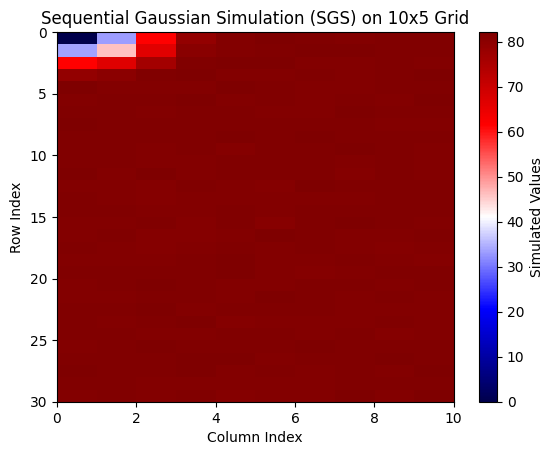

In [10]:
# TO CHECK

# SGS prediction with no previous known data, using the variogram

# Parameters from previous fitted variogram
#nugget, sill, range_ = var_parameters
nugget, sill, range_ = 0.0, 0.01, 3.57

# Activate/Deactivate grid as needed

# Grid for SGS
#n_rows_sgs_grid, n_cols_sgs_grid = 30, 10
#sgs_grid_points = np.array([(i, j) for i in range(n_rows_sgs_grid) for j in range(n_cols_sgs_grid)])

# Grid for SGS, in this case smaller than input to reduce computer resources
n_rows_sgs_grid, n_cols_sgs_grid = 30, 10
sgs_grid_points = []
for i in range(n_rows_sgs_grid):
    for j in range(n_cols_sgs_grid):
        sgs_grid_points.append((i, j))
sgs_grid_points = np.array(sgs_grid_points)

# Array initialization
simulated_values = np.zeros(n_rows_sgs_grid * n_cols_sgs_grid)

# Sequential Gaussian Simulation
def sequential_gaussian_simulation(sgs_grid_points, spherical_model, nugget, sill, range_, n_simulations=5, reg_factor=1e-5):
    for sim in range(n_simulations):
        for idx in range(len(sgs_grid_points)):
            # Combine previously simulated points
            known_indices = np.where(simulated_values != 0)[0]  # Get indices from already simulated points
            current_point = sgs_grid_points[idx]
            
            # Check if there are simulated points, skip otherwise
            if len(known_indices) == 0:
                simulated_values[idx] = np.random.normal(0, np.sqrt(sill))
                continue

            # Computations of distances
            dist_matrix = distance_matrix([current_point], sgs_grid_points[known_indices])
            known_dist_matrix = distance_matrix(sgs_grid_points[known_indices], sgs_grid_points[known_indices])
            
            # Covariance matrices
            cov_known = spherical_model(known_dist_matrix, nugget, sill, range_)
            cov_grid_known = spherical_model(dist_matrix, nugget, sill, range_)

            # Regularization (nugget effect to diagonal to avoid singular matrix)
            cov_known += np.eye(cov_known.shape[0]) * reg_factor
            
            try:
                # Kriging system solution:: λ * cov_known = cov_grid_known
                weights = np.linalg.solve(cov_known, cov_grid_known.T)
                # Prediction of new value
                mean = weights.T @ simulated_values[known_indices]
                variance = np.maximum(sill - np.einsum('ij,ij->i', weights.T, cov_grid_known), 0)  # Ensure non-negative variance
                simulated_value = np.random.normal(mean, np.sqrt(variance))
                simulated_values[idx] = simulated_value

            except np.linalg.LinAlgError:
                print(f"Singular matrix encountered at point {idx}, simulation {sim}. Using fallback.")
                simulated_values[idx] = np.random.normal(0, np.sqrt(sill))

    return simulated_values

# Simulation
simulated_values = sequential_gaussian_simulation(sgs_grid_points, spherical_model, nugget, sill, range_)

# Reshape
simulated_values_2d = simulated_values.reshape(n_rows_sgs_grid, n_cols_sgs_grid)


# Plot
plt.imshow(simulated_values_2d, cmap='seismic', extent=[0, n_cols_sgs_grid, n_rows_sgs_grid, 0], aspect='auto')
plt.colorbar(label='Simulated Values')
plt.title('Sequential Gaussian Simulation (SGS) on 10x5 Grid')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

C:\Users\cco\AppData\Local\Temp\ipykernel_12412\1099209402.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simulated_values[idx] = simulated_value
C:\Users\cco\AppData\Local\Temp\ipykernel_12412\1099209402.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  uncertainty_values[idx] = variance
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


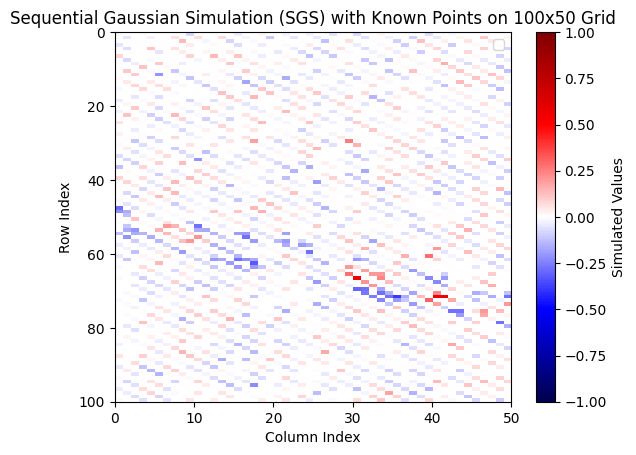

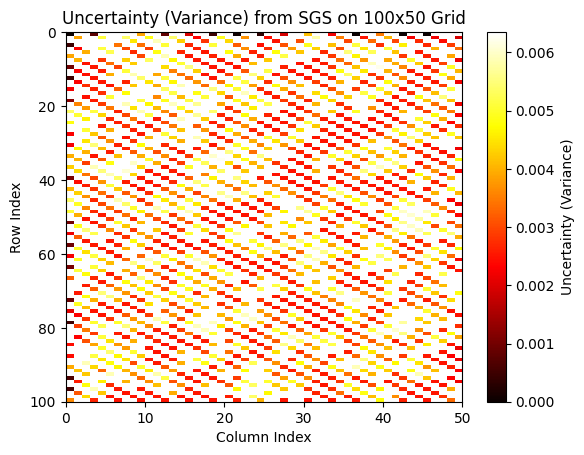

In [14]:
# SGS prediction with previous known data taken from the input data, using the variogram

# Parameters from previous fitted variogram
#nugget, sill, range_ = var_parameters
nugget, sill, range_ = 0.0, 0.01, 3.57

# Grid for SGS prediction, in this case smaller than input to reduce computer resources
n_rows_sgs_grid, n_cols_sgs_grid = 100, 50
sgs_grid_points = []
for i in range(n_rows_sgs_grid):
    for j in range(n_cols_sgs_grid):
        sgs_grid_points.append((i, j))
sgs_grid_points = np.array(sgs_grid_points)

# Initializations of arrays
simulated_values = np.full(n_rows_sgs_grid * n_cols_sgs_grid, np.nan)  # Start with NaNs
uncertainty_values = np.full(n_rows_sgs_grid * n_cols_sgs_grid, np.nan)  # Initialize uncertainty array

# Know points (in this case from input data)
known_data_mask = np.random.rand(n_rows_sgs_grid, n_cols_sgs_grid) < 0.1  # Randomly select 10% as known
known_indices = np.where(known_data_mask.ravel())[0]
simulated_values[known_indices] = seismic_data.ravel()[known_indices]

# Sequential Gaussian Simulation
def sequential_gaussian_simulation(sgs_grid_points, spherical_model, nugget, sill, range_, n_simulations=5, reg_factor=1e-5):
    for sim in range(n_simulations):
        for idx in range(0, len(sgs_grid_points), 3):
            # If current point is already known, skip it
            if not np.isnan(simulated_values[idx]):
                continue

            # Combine previously simulated and known points
            known_indices = np.where(~np.isnan(simulated_values))[0]  # Get indices of known and already simulated points
            current_point = sgs_grid_points[idx]

            # Check if there are simulated points, skip otherwise
            if len(known_indices) == 0:
                simulated_values[idx] = np.random.normal(0, np.sqrt(sill))
                uncertainty_values[idx] = sill
                continue

            # Computations of distances
            dist_matrix = distance_matrix([current_point], sgs_grid_points[known_indices])
            known_dist_matrix = distance_matrix(sgs_grid_points[known_indices], sgs_grid_points[known_indices])

            # Covariance matrices
            cov_known = spherical_model(known_dist_matrix, nugget, sill, range_)
            cov_grid_known = spherical_model(dist_matrix, nugget, sill, range_)

            # Regularization (nugget effect to diagonal to avoid singular matrix)
            cov_known += np.eye(cov_known.shape[0]) * reg_factor

            try:
                # Kriging system solution: λ * cov_known = cov_grid_known
                weights = np.linalg.solve(cov_known, cov_grid_known.T)

                # Prediction of new value
                mean = weights.T @ simulated_values[known_indices]
                variance = np.maximum(sill - np.einsum('ij,ij->i', weights.T, cov_grid_known), 0)  # Ensure non-negative variance
                simulated_value = np.random.normal(mean, np.sqrt(variance))
                simulated_values[idx] = simulated_value
                uncertainty_values[idx] = variance

            except np.linalg.LinAlgError:
                print(f"Singular matrix encountered at point {idx}, simulation {sim}. Using fallback.")
                simulated_values[idx] = np.random.normal(0, np.sqrt(sill))
                uncertainty_values[idx] = sill

    return simulated_values, uncertainty_values

# Simulation
simulated_values, uncertainty_values = sequential_gaussian_simulation(sgs_grid_points, spherical_model, nugget, sill, range_)

# Reshape
simulated_values_2d = simulated_values.reshape(n_rows_sgs_grid, n_cols_sgs_grid)
uncertainty_values_2d = uncertainty_values.reshape(n_rows_sgs_grid, n_cols_sgs_grid)


# Plots
# Predicted values
plt.imshow(simulated_values_2d, cmap='seismic', extent=[0, n_cols_sgs_grid, n_rows_sgs_grid, 0], aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Simulated Values')
#plt.scatter(*np.where(known_data_mask), color='black', label='Known Data Points', s=10)
plt.legend()
plt.title('Sequential Gaussian Simulation (SGS) with Known Points on 100x50 Grid')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

# Kriging variance (uncertainty)
plt.imshow(uncertainty_values_2d, cmap='hot', extent=[0, n_cols_sgs_grid, n_rows_sgs_grid, 0], aspect='auto')
plt.colorbar(label='Uncertainty (Variance)')
plt.title('Uncertainty (Variance) from SGS on 100x50 Grid')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()